# Supervised Learning Project

## Context:

This case is about a bank (Thera Bank) whose management wants to explore ways of
converting its liability customers to personal loan customers (while retaining them as
depositors). A campaign that the bank ran last year for liability customers showed a
healthy conversion rate of over 9% success. This has encouraged the retail marketing
department to devise campaigns with better target marketing to increase the success
ratio with minimal budget.

## Data description:

The file Bank.xls contains data on 5000 customers. The data include customer
demographic information (age, income, etc.), the customer's relationship with the bank
(mortgage, securities account, etc.), and the customer response to the last personal loan
campaign (Personal Loan). Among these 5000 customers, only 480 (= 9.6%) accepted
the personal loan that was offered to them in the earlier campaign.

## Attribute information:

**ID:** Customer ID  
**Age:** Customer's age in completed years  
**Experience:**  #years of professional experience  
**Income:** Annual income of the customer (\$000)  
**ZIP Code:** Home Address ZIP code  
**Family:**  Family size of the customer  
**CCAvg:** Avg. spending on credit cards per month ($000)  
**Education:**  Education Level. 1: Undergrad; 2: Graduate; 3: Advanced/Professional  
**Mortgage:** Value of house mortgage if any. (\$000)  
**Personal Loan:** Did this customer accept the personal loan offered in the last campaign?  
**Securities Account:** Does the customer have a securities account with the bank?  
**CD Account:** Does the customer have a certificate of deposit (CD) account with the bank?  
**Online:** Does the customer use internet banking facilities?  
**Credit card:** Does the customer use a credit card issued by UniversalBank?  

## Objective:

The classification goal is to predict the likelihood of a liability customer buying personal
loans.

In [1]:
# Import necessary libraries

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Read csv file as dataframe

bank_loan_df = pd.read_csv('Bank_Personal_Loan_Modelling.csv')
bank_loan_df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [3]:
# Check the shape, null values and data type of each attribute
bank_loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
ID                    5000 non-null int64
Age                   5000 non-null int64
Experience            5000 non-null int64
Income                5000 non-null int64
ZIP Code              5000 non-null int64
Family                5000 non-null int64
CCAvg                 5000 non-null float64
Education             5000 non-null int64
Mortgage              5000 non-null int64
Personal Loan         5000 non-null int64
Securities Account    5000 non-null int64
CD Account            5000 non-null int64
Online                5000 non-null int64
CreditCard            5000 non-null int64
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


#### There 5000 rows with 14 columns (no string-types) having no null values...

In [4]:
# Drop ID column
bank_loan_df.drop('ID', axis=1, inplace=True)

In [5]:
# Check the data distribution within the columns
bank_loan_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,5000.0,45.338400,11.463166,23.0,35.0,45.0,55.0,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.0,20.0,30.0,43.0
Income,5000.0,73.774200,46.033729,8.0,39.0,64.0,98.0,224.0
ZIP Code,5000.0,93152.503000,2121.852197,9307.0,91911.0,93437.0,94608.0,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.0,2.0,3.0,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.7,1.5,2.5,10.0
Education,5000.0,1.881000,0.839869,1.0,1.0,2.0,3.0,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.0,0.0,101.0,635.0
Personal Loan,5000.0,0.096000,0.294621,0.0,0.0,0.0,0.0,1.0
Securities Account,5000.0,0.104400,0.305809,0.0,0.0,0.0,0.0,1.0


#### The minimum experience is -ve... Let's check for outliers in each continuous feature and their count

In [6]:
# Define function to calculate and print out the outlier count

def get_outlier_summary(data, cols, return_index=False):
    """
    Identifies the outliers in the data
    and returns the column-wise outlier indices
    
    Extended description of function.

    Parameters
    ----------
    data : pd.DataFrame
        The dataframe in which to find the outliers
    
    cols : list like iterable
        Columns across which to find the outliers
    
    return_index : Boolean, default=False
        If True, returns the combined set of indices having outliers in at least one column
    
    Returns
    ----------
    set or int
        Based on return_index, returns either 
        combined set of indices having outlier in at least one column or 
        outliers count
    """
    
    global_indices = set()
    q1 = data[cols].quantile(0.25)
    q3 = data[cols].quantile(0.75)
    iqr = q3 - q1
    min_val = q1 - 1.5*iqr
    max_val = q3 + 1.5*iqr
    
    for col in cols:
        outliers = data[(data[col] > max_val[col]) | (data[col] < min_val[col])][col]
        outlier_count = outliers.count()
        local_indices = outliers.index
        global_indices.update(local_indices)
        print(f"Outliers in {col} are {outlier_count}")
            
    return global_indices if return_index else len(global_indices)

# Get the outlier in continuous features
outliers = get_outlier_summary(bank_loan_df, ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage'])
print(f"Total outliers: {outliers}")

Outliers in Age are 0
Outliers in Experience are 0
Outliers in Income are 96
Outliers in CCAvg are 324
Outliers in Mortgage are 291
Total outliers: 602


#### To decide if we should remove the outliers, we need to have a look at the distribution for these variables. But first, let's remove the samples where experience is -ve (as it is bound to be a data gathering/recording error).

In [7]:
# Remove rows where experience is -ve

bank_loan_df = bank_loan_df[bank_loan_df['Experience'] >= 0]

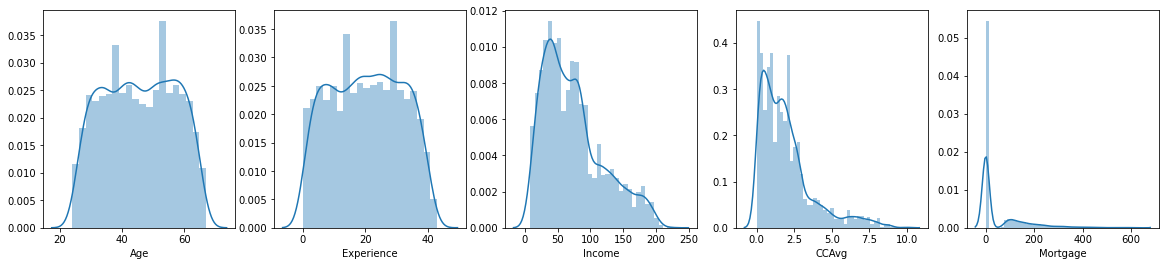

In [8]:
# Check distributions for continuous variables
continuous_vars = ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage']
f, axes = plt.subplots(1, 5, figsize=(20,4))

for i, var in enumerate(continuous_vars):
    sns.distplot(bank_loan_df[var], ax=axes[i])

**Age** and **Experience** seem to be fairly **evenly** distributed across the range.  
**Income** and **CCAvg** follows a **heavily left skewed** distribution.  
**Mortgage** also follows a **heavily left skewed** distribution with most customers not mortgaging the house.  

#### Coming back to outliers, we see that due to the nature of distribution of Income, CCAvg and Mortgage, mostly the larger values seem like outliers,  
#### But in practice, they shouldn't be considered as outliers as they represent the true distribution that is prevalent in real world and very inherent to the nature of the corresponding features. Also, these outliers may capture some important information as well

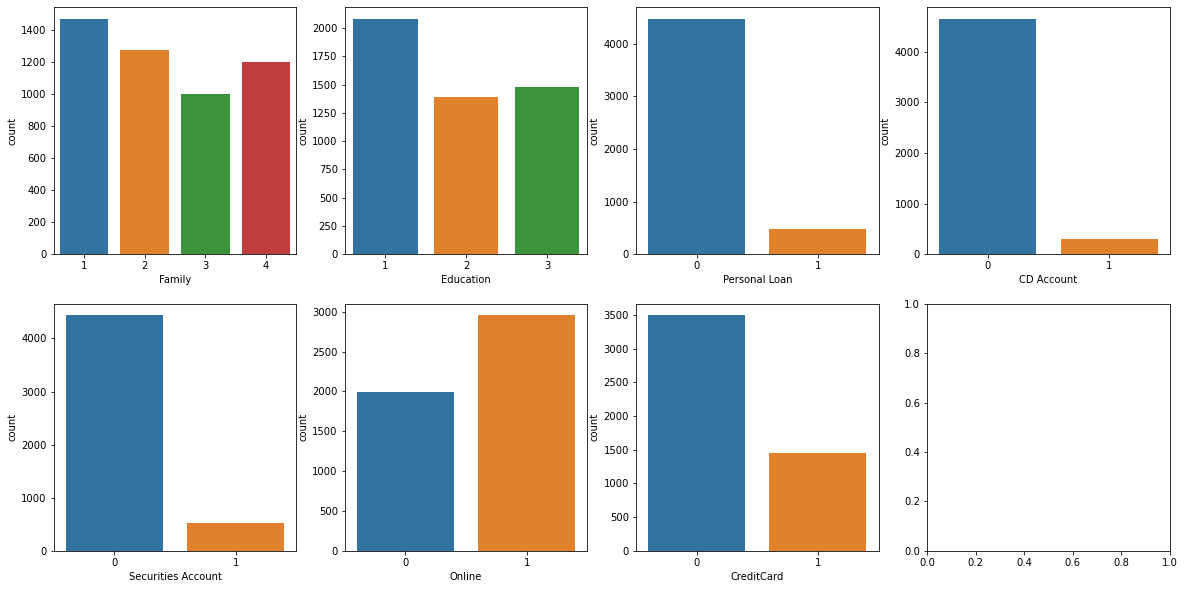

In [9]:
# Check distributions for discrete variables
discrete_vars = ['Family', 'Education', 'Personal Loan', 'CD Account', 'Securities Account', 'Online', 'CreditCard']
f, axes = plt.subplots(2, 4, figsize=(20,10))

for i, var in enumerate(discrete_vars):
    sns.countplot(x=bank_loan_df[var], orient='v', ax=axes.flatten()[i])

**Family**: Majority of the customers have either 1 or 2 members in their family.  
**Education**: Majority of the customers are either graduates or professionals.  
**Personal Loan**: This is our target variable. The dataset is highly imbalanced with only about 9% taking personal loan.  
**CD Account**: Only ~6-7% of customers have a CD account with the bank.  
**Securities Account**: Only ~ 10% customers have Securities account with the bank.  
**Online**: Around 60% customers use the bank's internet banking facility.  
**CreditCard**: Around 30% customers use a credit card issued by Universal Bank.  

## Some Bivariate analysis:

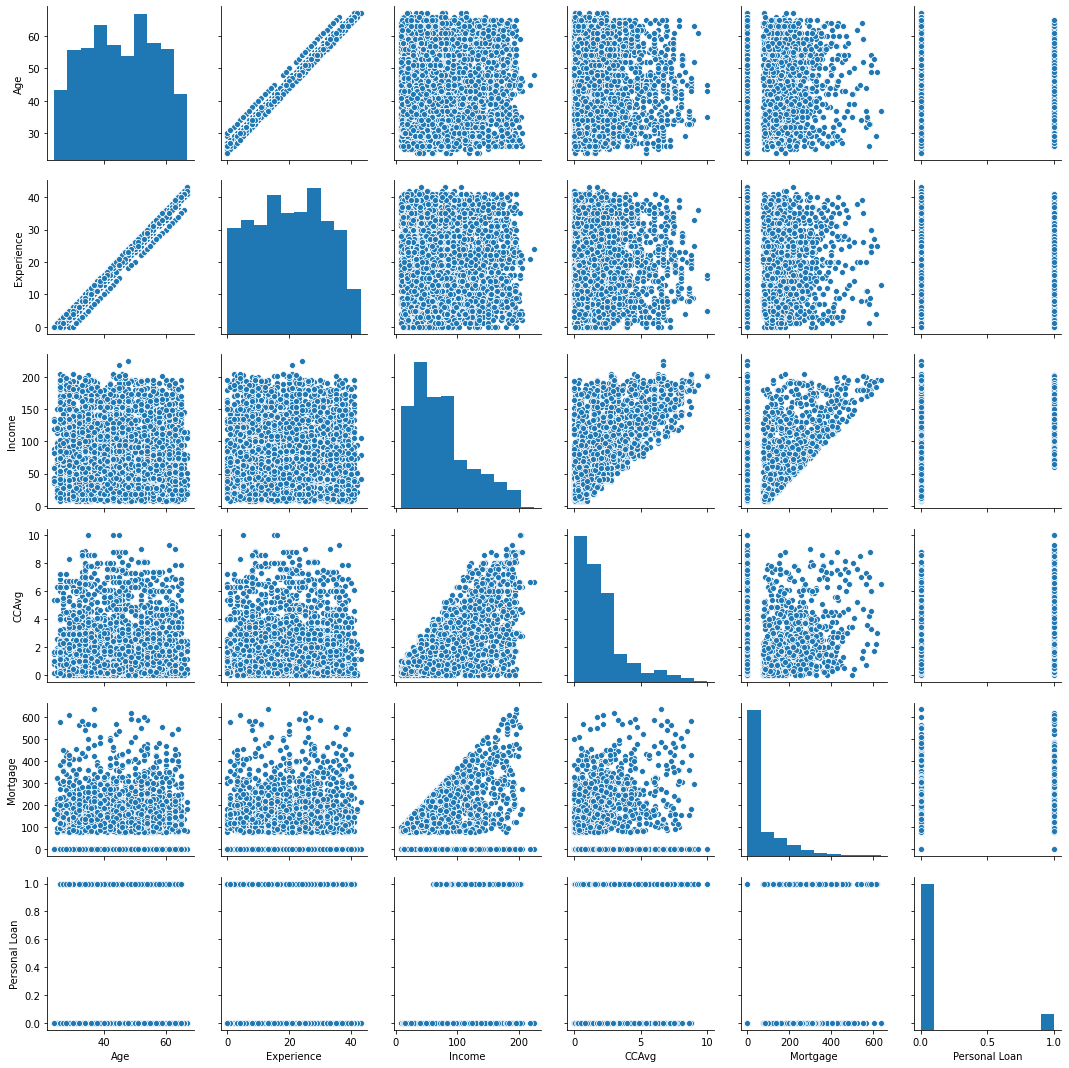

In [10]:
# We use seaborn pairplot to do the bivariate analysis for continuous features and target 

sns.pairplot(bank_loan_df, vars=['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage', 'Personal Loan'])

#### There is obvious correlation between Age and Experience.
#### Each of CCAvg and Mortgage seem to be somewhat correlated with Income. We need to see the correlation plot to be able to quantify these...

## Some Multivariate analysis:

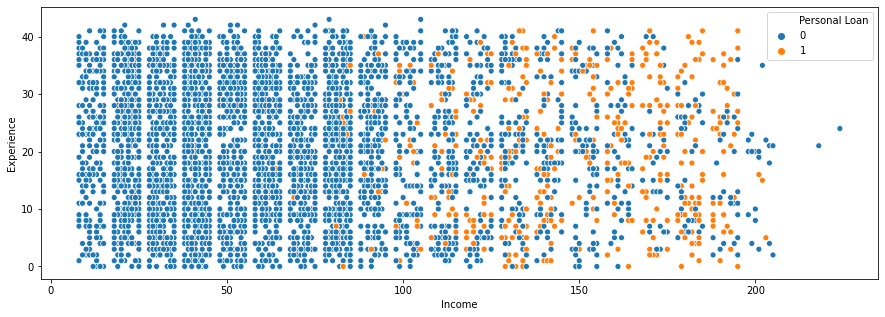

In [11]:
# Income vs Experience split by personal loan
f, axes = plt.subplots(1, 1, figsize=(15,5))

sns.scatterplot(x='Income', y='Experience', data=bank_loan_df, hue='Personal Loan', ax=axes)

**This shows, irrespective of Experience, more number of higher income customers seems to have taken loan**

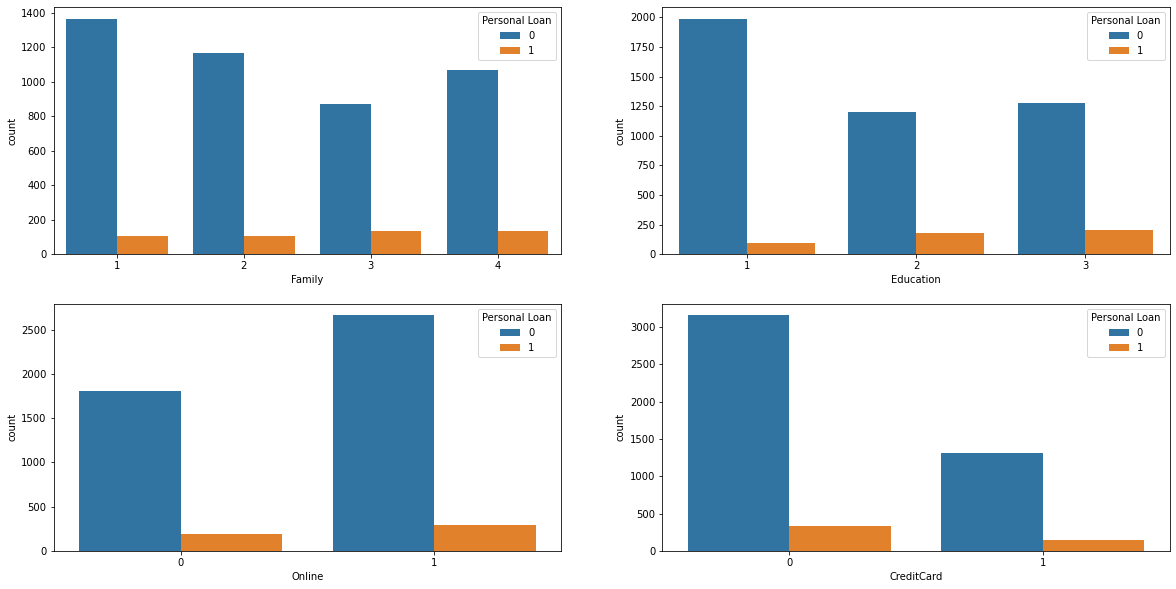

In [12]:
# Categorical vars vs personal loan
categ_vars = ['Family', 'Education', 'Online', 'CreditCard']
f, axes = plt.subplots(2, 2, figsize=(20,10))

for i, var in enumerate(categ_vars):
    sns.countplot(x=bank_loan_df[var], hue=bank_loan_df['Personal Loan'], orient='v', ax=axes.flatten()[i])

**The distribution of loans seem to be fairly uniform but loan seem to be more popular among more educated customers**

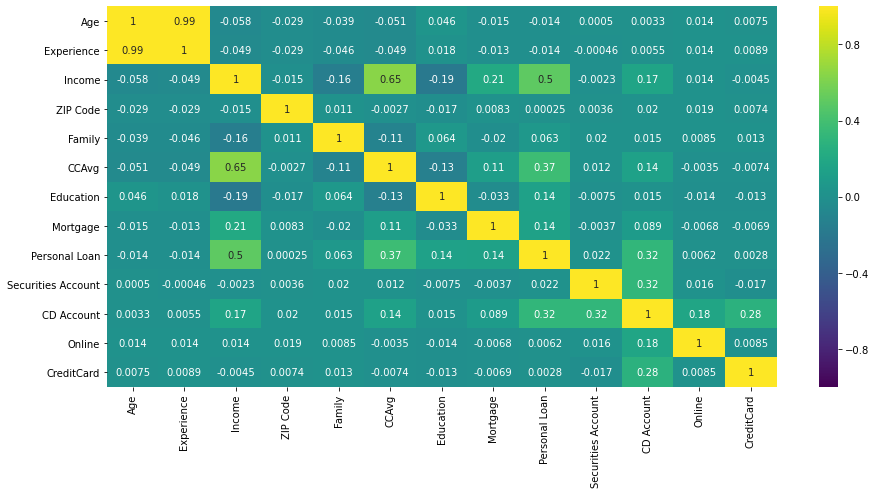

In [13]:
# Correlation among variables
plt.figure(figsize=[15,7])

sns.heatmap(bank_loan_df.corr(), cmap='viridis', vmin=-1, vmax=1, annot=True)

#### Observations:
Good correlation between **CCAvg and Income**  
Good correlation between **Personal loan and Income**  

In [14]:
# Target variable distribution

bank_loan_df['Personal Loan'].value_counts(normalize=True)

0    0.902991
1    0.097009
Name: Personal Loan, dtype: float64

#### The dataset is heavily imbalanced (Only has 9.7% customers who took loan)

## Model Building starts...

In [15]:
from sklearn.model_selection import train_test_split

X = bank_loan_df.drop('Personal Loan', axis=1)
y = bank_loan_df['Personal Loan']

# Note: Set stratify to make sure class imbalances are preserved after split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)

# Verify distribution of target variable in test set
y_test.value_counts(normalize=True)

0    0.90303
1    0.09697
Name: Personal Loan, dtype: float64

#### Since many of continuous features have a larger scale, we need to scale them out to bring them closer to categorical features.
#### For this, we will use MinMaxScaler (and not StandardScaler) which will preserve the distribution of the data in features
#### Note: We do the scaling seperately on train and test set so as to mimic the real world scenario where we obviously can't scale the incoming data with train data that has been used to build the model

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.fit_transform(X_test, y_test)

### Build and test the following models:  
    1. Naive Bayes  
    2. Logistic    
    3. KNN  
    4. SVM  
#### First we will set the base line for accuracy using Naive Bayes and then use Grid search CV to find the best hyper-parameters for other models

In [17]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      1341
           1       0.44      0.63      0.52       144

    accuracy                           0.88      1485
   macro avg       0.70      0.77      0.73      1485
weighted avg       0.91      0.88      0.89      1485



#### Although we get an accuracy of 88% using Naive Bayes, but a poor f1-score for class 1. We can hope for better performance with the remaining models

### Now we find the best hyper parameters for each of the above models using Grid search CV
**Note:** We will be leaving out Naive-Bayes as there isn't much tuning that can be done

In [18]:
# We create a generic grid search function which can be used for multiple ML models/algorithms

from sklearn.model_selection import GridSearchCV

def get_best_model(X, y, estimator_specs):
    """
    Finds the best model among the estimators among all possible ones
    as defined in param_grid and returns the best estimator.

    Extended description of function.

    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        Samples vector, where n_samples is the number of samples and
        n_features is the number of features.
    
    y : array-like of shape (n_samples,)
        Target vector relative to X.
    
    estimator_specs : list of dictionaries
        List of dictionaries where each dictionary specifies the details of a single estimator object.
        The dictionary has following keys and values:
        
            estimator  : estimator object
                An estimator object (classifier instance)
                
            params : dict or list of dictionaries
                Dictionary with parameters names (string) as keys and lists of parameter settings to try as values,
                or a list of such dictionaries, in which case the grids spanned by each dictionary in the list are explored.
                This enables searching over any sequence of parameter settings.
                
            scorer : scoring function or None
                A custom scoring function. This goes as a value to 'scoring' argument in GridSearchCV.
                If None, then estimator's score function is used.
    
    Returns
    -------
    List of estimator objects(as dictionaries)
        List of dictionaries of best estimator object (which has best score) along with their scores and results.

    """
    
    results = list()
    for estimator in estimator_specs:
        best_estimator = dict()
        gs_object = GridSearchCV(estimator['estimator'],
                                param_grid=estimator['params'],
                                scoring=estimator['scorer'],
                                cv=4,
                                verbose=2)
        gs_object.fit(X, y)
        best_estimator['estimator'] = gs_object.best_estimator_
        best_estimator['score'] = gs_object.best_score_
        best_estimator['results'] = pd.DataFrame(gs_object.cv_results_).drop('params', axis=1)
        results.append(best_estimator)
    
    return results

In [19]:
# We define the parameter grids for each of the models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Logistic Regression
logsitic_params = [
    {'C': [0.01, 0.1, 0.5, 1.0, 10, 100, 1000], 'solver': ['liblinear'], 'penalty': ['l1', 'l2']},
    {'C': [0.01, 0.1, 0.5, 1.0, 10, 100, 1000], 'solver': ['lbfgs'], 'penalty': ['l2']}
]

# KNN
knn_params = {'n_neighbors': [5, 11, 19, 25, 33, 35, 39, 43],
              'metric': ['manhattan', 'euclidean'],
              'algorithm': ['auto', 'kd_tree']}

# SVM
svm_params = {'C': [0.01, 0.1, 1, 10],
              'gamma': [0.01, 0.1, 1, 10],
              'kernel': ['poly', 'rbf']}

# We will use the roc_auc_score as our custom scorer
from sklearn.metrics import make_scorer, roc_auc_score
custom_scorer = make_scorer(roc_auc_score, needs_proba=True)

# Define estimator specs for each model to be passed into get_best_model()
estimator_specs = [
    {
        # Logistic Regression
        'estimator': LogisticRegression(max_iter=1000, random_state=42),
        'params'   : logsitic_params,
        'scorer'   : custom_scorer
    },
    {
        # KNN
        'estimator': KNeighborsClassifier(),
        'params'   : knn_params,
        'scorer'   : custom_scorer
    },
    {
        # SVM
        'estimator': SVC(random_state=42, probability=True),
        'params'   : svm_params,
        'scorer'   : custom_scorer
    }
]

# We will be providing grid search with complete dataset as it internally would use stratified k-fold cross validation
# Hence, we need to scale the whole data prior to that

X = scaler.fit_transform(X, y)

results = get_best_model(X, y, estimator_specs)

Fitting 4 folds for each of 21 candidates, totalling 84 fits
[CV] C=0.01, penalty=l1, solver=liblinear ............................
[CV] ............. C=0.01, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=0.01, penalty=l1, solver=liblinear ............................
[CV] ............. C=0.01, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=0.01, penalty=l1, solver=liblinear ............................
[CV] ............. C=0.01, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=0.01, penalty=l1, solver=liblinear ............................
[CV] ............. C=0.01, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=0.01, penalty=l2, solver=liblinear ............................
[CV] ............. C=0.01, penalty=l2, solver=liblinear, total=   0.0s
[CV] C=0.01, penalty=l2, solver=liblinear ............................
[CV] ............. C=0.01, penalty=l2, solver=liblinear, total=   0.0s
[CV] C=0.01, penalty=l2, solver=liblinear ............................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .............. C=0.1, penalty=l1, solver=liblinear, total=   0.2s
[CV] C=0.1, penalty=l1, solver=liblinear .............................
[CV] .............. C=0.1, penalty=l1, solver=liblinear, total=   0.2s
[CV] C=0.1, penalty=l1, solver=liblinear .............................
[CV] .............. C=0.1, penalty=l1, solver=liblinear, total=   0.2s
[CV] C=0.1, penalty=l1, solver=liblinear .............................
[CV] .............. C=0.1, penalty=l1, solver=liblinear, total=   0.1s
[CV] C=0.1, penalty=l2, solver=liblinear .............................
[CV] .............. C=0.1, penalty=l2, solver=liblinear, total=   0.0s
[CV] C=0.1, penalty=l2, solver=liblinear .............................
[CV] .............. C=0.1, penalty=l2, solver=liblinear, total=   0.0s
[CV] C=0.1, penalty=l2, solver=liblinear .............................
[CV] .............. C=0.1, penalty=l2, solver=liblinear, total=   0.0s
[CV] C=0.1, penalty=l2, solver=liblinear .............................
[CV] .

[CV] .................. C=0.5, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=0.5, penalty=l2, solver=lbfgs .................................
[CV] .................. C=0.5, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................
[CV] .................. C=1.0, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................
[CV] .................. C=1.0, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................
[CV] .................. C=1.0, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................
[CV] .................. C=1.0, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=10, penalty=l2, solver=lbfgs ..................................
[CV] ................... C=10, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=10, penalty=l2, solver=lbfgs ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:   13.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Fitting 4 folds for each of 32 candidates, totalling 128 fits
[CV] algorithm=auto, metric=manhattan, n_neighbors=5 .................
[CV] .. algorithm=auto, metric=manhattan, n_neighbors=5, total=   0.1s
[CV] algorithm=auto, metric=manhattan, n_neighbors=5 .................
[CV] .. algorithm=auto, metric=manhattan, n_neighbors=5, total=   0.1s
[CV] algorithm=auto, metric=manhattan, n_neighbors=5 .................
[CV] .. algorithm=auto, metric=manhattan, n_neighbors=5, total=   0.1s
[CV] algorithm=auto, metric=manhattan, n_neighbors=5 .................
[CV] .. algorithm=auto, metric=manhattan, n_neighbors=5, total=   0.1s
[CV] algorithm=auto, metric=manhattan, n_neighbors=11 ................
[CV] . algorithm=auto, metric=manhattan, n_neighbors=11, total=   0.1s
[CV] algorithm=auto, metric=manhattan, n_neighbors=11 ................
[CV] . algorithm=auto, metric=manhattan, n_neighbors=11, total=   0.1s
[CV] algorithm=auto, metric=manhattan, n_neighbors=11 ................
[CV] . algorith

[CV] . algorithm=auto, metric=euclidean, n_neighbors=39, total=   0.1s
[CV] algorithm=auto, metric=euclidean, n_neighbors=39 ................
[CV] . algorithm=auto, metric=euclidean, n_neighbors=39, total=   0.1s
[CV] algorithm=auto, metric=euclidean, n_neighbors=39 ................
[CV] . algorithm=auto, metric=euclidean, n_neighbors=39, total=   0.1s
[CV] algorithm=auto, metric=euclidean, n_neighbors=43 ................
[CV] . algorithm=auto, metric=euclidean, n_neighbors=43, total=   0.1s
[CV] algorithm=auto, metric=euclidean, n_neighbors=43 ................
[CV] . algorithm=auto, metric=euclidean, n_neighbors=43, total=   0.1s
[CV] algorithm=auto, metric=euclidean, n_neighbors=43 ................
[CV] . algorithm=auto, metric=euclidean, n_neighbors=43, total=   0.1s
[CV] algorithm=auto, metric=euclidean, n_neighbors=43 ................
[CV] . algorithm=auto, metric=euclidean, n_neighbors=43, total=   0.1s
[CV] algorithm=kd_tree, metric=manhattan, n_neighbors=5 ..............
[CV]  

[CV]  algorithm=kd_tree, metric=euclidean, n_neighbors=33, total=   0.1s
[CV] algorithm=kd_tree, metric=euclidean, n_neighbors=35 .............
[CV]  algorithm=kd_tree, metric=euclidean, n_neighbors=35, total=   0.1s
[CV] algorithm=kd_tree, metric=euclidean, n_neighbors=35 .............
[CV]  algorithm=kd_tree, metric=euclidean, n_neighbors=35, total=   0.1s
[CV] algorithm=kd_tree, metric=euclidean, n_neighbors=35 .............
[CV]  algorithm=kd_tree, metric=euclidean, n_neighbors=35, total=   0.1s
[CV] algorithm=kd_tree, metric=euclidean, n_neighbors=35 .............
[CV]  algorithm=kd_tree, metric=euclidean, n_neighbors=35, total=   0.1s
[CV] algorithm=kd_tree, metric=euclidean, n_neighbors=39 .............
[CV]  algorithm=kd_tree, metric=euclidean, n_neighbors=39, total=   0.1s
[CV] algorithm=kd_tree, metric=euclidean, n_neighbors=39 .............
[CV]  algorithm=kd_tree, metric=euclidean, n_neighbors=39, total=   0.1s
[CV] algorithm=kd_tree, metric=euclidean, n_neighbors=39 ......

[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:   14.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. C=0.01, gamma=0.01, kernel=poly, total=   0.5s
[CV] C=0.01, gamma=0.01, kernel=poly .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .................. C=0.01, gamma=0.01, kernel=poly, total=   0.5s
[CV] C=0.01, gamma=0.01, kernel=poly .................................
[CV] .................. C=0.01, gamma=0.01, kernel=poly, total=   0.5s
[CV] C=0.01, gamma=0.01, kernel=poly .................................
[CV] .................. C=0.01, gamma=0.01, kernel=poly, total=   0.5s
[CV] C=0.01, gamma=0.01, kernel=rbf ..................................
[CV] ................... C=0.01, gamma=0.01, kernel=rbf, total=   0.8s
[CV] C=0.01, gamma=0.01, kernel=rbf ..................................
[CV] ................... C=0.01, gamma=0.01, kernel=rbf, total=   1.0s
[CV] C=0.01, gamma=0.01, kernel=rbf ..................................
[CV] ................... C=0.01, gamma=0.01, kernel=rbf, total=   0.9s
[CV] C=0.01, gamma=0.01, kernel=rbf ..................................
[CV] ................... C=0.01, gamma=0.01, kernel=rbf, total=   0.9s
[CV] C=0.01, gamma=0.1, kernel=poly ..................................
[CV] .

[CV] ..................... C=0.1, gamma=10, kernel=poly, total=   4.0s
[CV] C=0.1, gamma=10, kernel=rbf .....................................
[CV] ...................... C=0.1, gamma=10, kernel=rbf, total=   1.9s
[CV] C=0.1, gamma=10, kernel=rbf .....................................
[CV] ...................... C=0.1, gamma=10, kernel=rbf, total=   1.9s
[CV] C=0.1, gamma=10, kernel=rbf .....................................
[CV] ...................... C=0.1, gamma=10, kernel=rbf, total=   2.0s
[CV] C=0.1, gamma=10, kernel=rbf .....................................
[CV] ...................... C=0.1, gamma=10, kernel=rbf, total=   2.0s
[CV] C=1, gamma=0.01, kernel=poly ....................................
[CV] ..................... C=1, gamma=0.01, kernel=poly, total=   0.4s
[CV] C=1, gamma=0.01, kernel=poly ....................................
[CV] ..................... C=1, gamma=0.01, kernel=poly, total=   0.4s
[CV] C=1, gamma=0.01, kernel=poly ....................................
[CV] .

[CV] ........................ C=10, gamma=1, kernel=rbf, total=   0.5s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........................ C=10, gamma=1, kernel=rbf, total=   0.5s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........................ C=10, gamma=1, kernel=rbf, total=   0.5s
[CV] C=10, gamma=10, kernel=poly .....................................
[CV] ...................... C=10, gamma=10, kernel=poly, total=   8.5s
[CV] C=10, gamma=10, kernel=poly .....................................
[CV] ...................... C=10, gamma=10, kernel=poly, total=  11.0s
[CV] C=10, gamma=10, kernel=poly .....................................
[CV] ...................... C=10, gamma=10, kernel=poly, total=  20.7s
[CV] C=10, gamma=10, kernel=poly .....................................
[CV] ...................... C=10, gamma=10, kernel=poly, total=  14.8s
[CV] C=10, gamma=10, kernel=rbf ......................................
[CV] .

[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:  3.3min finished


In [20]:
for algo in results:
    print(f"Best Estimator: {algo['estimator']}")
    print(f"Best Score: {algo['score']}\n")

Best Estimator: LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
Best Score: 0.9591987466427931

Best Estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=33, p=2,
                     weights='uniform')
Best Score: 0.9712016935243212

Best Estimator: SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)
Best Score: 0.9879961205610266



#### We have the best estimator for each of the algorithms and see that these have very close scores with SVM performing the best.
**Note:** We have defined our custom scorer which is roc_auc_score metric. Accuracy can be misleading when there are class imbalances. Also, we have used class probablities instead of class labels while scoring because this will later help us to find the optimum threshold to maximize f1-score

#### Let's see the results for each estimator runs more closely:

In [21]:
# Best 10 Logistic Regression CV results

results[0]['results'][['param_C', 'param_penalty', 'param_solver', 'mean_test_score', 'rank_test_score']] \
    .sort_values('rank_test_score').head(10)

,param_C,param_penalty,param_solver,mean_test_score,rank_test_score
5,0.5,l2,liblinear,0.959199,1
7,1,l2,liblinear,0.959178,2
16,0.5,l2,lbfgs,0.958889,3
17,1,l2,lbfgs,0.958850,4
4,0.5,l1,liblinear,0.958699,5
9,10,l2,liblinear,0.958531,6
6,1,l1,liblinear,0.958522,7
18,10,l2,lbfgs,0.958421,8
8,10,l1,liblinear,0.958276,9
11,100,l2,liblinear,0.958272,10


In [22]:
# Best 10 KNN CV results

results[1]['results'][['param_algorithm', 'param_metric', 'param_n_neighbors', 'mean_test_score', 'rank_test_score']] \
    .sort_values('rank_test_score').head(10)

,param_algorithm,param_metric,param_n_neighbors,mean_test_score,rank_test_score
4,auto,manhattan,33,0.971202,1
20,kd_tree,manhattan,33,0.971202,1
5,auto,manhattan,35,0.970981,3
21,kd_tree,manhattan,35,0.970981,3
3,auto,manhattan,25,0.970510,5
19,kd_tree,manhattan,25,0.970510,5
6,auto,manhattan,39,0.970327,7
22,kd_tree,manhattan,39,0.970327,7
23,kd_tree,manhattan,43,0.968923,9
7,auto,manhattan,43,0.968923,9


In [23]:
# Best 10 SVM CV results

results[2]['results'][['param_C', 'param_gamma', 'param_kernel', 'mean_test_score', 'rank_test_score']] \
    .sort_values('rank_test_score').head(10)

,param_C,param_gamma,param_kernel,mean_test_score,rank_test_score
20,1,1,poly,0.987996,1
12,0.1,1,poly,0.987453,2
29,10,1,rbf,0.986607,3
21,1,1,rbf,0.984994,4
28,10,1,poly,0.984255,5
6,0.01,10,poly,0.984253,6
26,10,0.1,poly,0.983888,7
4,0.01,1,poly,0.983881,8
23,1,10,rbf,0.983511,9
15,0.1,10,rbf,0.982806,10


### Let's evaluate the top model for each algorithm which will help us decide the best model

Classification report for Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1341
           1       0.87      0.59      0.70       144

    accuracy                           0.95      1485
   macro avg       0.91      0.79      0.84      1485
weighted avg       0.95      0.95      0.95      1485



Classification report for Model: KNN
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1341
           1       1.00      0.26      0.41       144

    accuracy                           0.93      1485
   macro avg       0.96      0.63      0.69      1485
weighted avg       0.93      0.93      0.91      1485



Classification report for Model: SVM
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1341
           1       0.91      0.90      0.91       144

    accuracy                           0.98      14

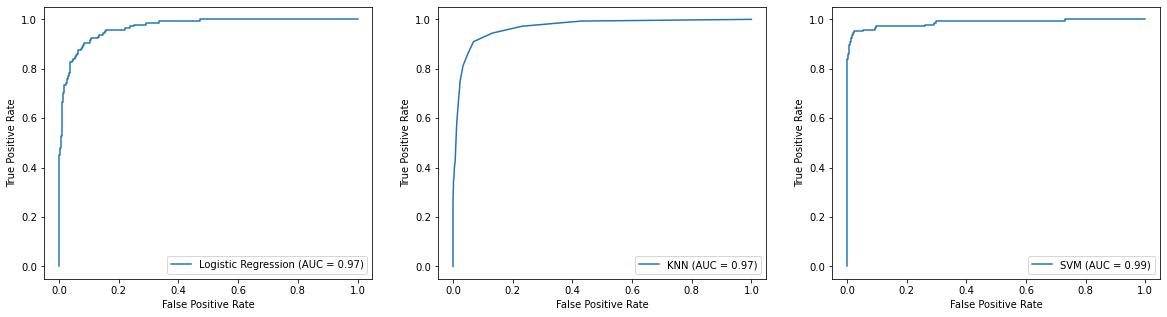

In [24]:
# We define a function which prints out the classification report for a model and the roc_auc_curve
from sklearn.metrics import plot_roc_curve
from time import sleep

def print_metrics(model, X_train, y_train, X_test, y_test, model_name=None, ax=None):
    """
    Fits the best estimator model on train set and predicts classes, then
    Prints out the classification report, roc_curve for the given model
    """
    
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(f"Classification report for Model: {model_name}")
    print(classification_report(y_test, predictions)+"\n\n")
    
    plot_roc_curve(model, X_test, y_test, name=model_name, ax=ax)

model_list = ['Logistic Regression', 'KNN', 'SVM']
f, axes = plt.subplots(1, 3, figsize=(20,5))
for i, model in enumerate(results):
    print_metrics(model['estimator'], X_train, y_train, X_test, y_test, model_name=model_list[i], ax=axes[i])

### Despite all of them having good accuracies and similar AUCs, we see that SVM outperforms other algorithms for Class 1 having better f1_score. 
### So we will proceed with SVM model and adjust threshold to see if we can improve f1_score for Class 1

In [25]:
# We will try out all the possible thresholds with SVM classifier to maximise f1_score

from sklearn.metrics import roc_curve, f1_score
from numpy import arange, argmax

# Choose SVM as the best estimator
best_estimator = results[2]['estimator']

best_estimator.fit(X_train, y_train)
pred_proba = best_estimator.predict_proba(X_test)[:, 1]

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

thresholds = arange(0, 1, 0.01)
scores = [f1_score(y_test, to_labels(pred_proba, t)) for t in thresholds]

# get best threshold
ix = argmax(scores)
optimal_threshold = thresholds[ix]
print(f'Threshold={round(optimal_threshold, 2)}, f1_score={round(scores[ix], 2)}')

Threshold=0.55, f1_score=0.91


### Let's create the labelled predictions with 0.55 threshold and again check the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1341
           1       0.93      0.90      0.91       144

    accuracy                           0.98      1485
   macro avg       0.96      0.94      0.95      1485
weighted avg       0.98      0.98      0.98      1485



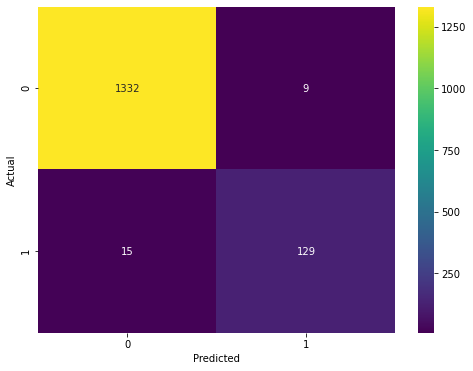

In [26]:
from sklearn.metrics import confusion_matrix
pred_labels = [1 if prob >= optimal_threshold else 0 for prob in pred_proba]

print(classification_report(y_test, pred_labels))

conf_mat = confusion_matrix(y_test, pred_labels)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='viridis')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### We see a marginal improvement in the precision while f1_score remains same for threshold of 0.55.

## Conclusion

Our main objective is to increase the success ratio with minimal budget. This means we need a good balance of both **Precision** as well as **Recall** for **Class 1**.  
Hence we first obtained the best model based on **roc_auc_score** instead of accuracy_score because our data has class imbalances  
And then we focussed on increasing the **f1_score** for that particular model by **tuning threshold**.  

With the results above we can say the following about our model:  
While keeping the budget optimal,   
**1. Out of the customers we target for a loan, 93% will take the loan (Precision).**  
**2. Out of the prospective loan taking customers, we successfully identify 90% of them (Recall).**